<font size="+2"><strong>Predicting Price with Size, Location, and Neighborhood</strong></font>

In this project I create a model that can predict the price of apartments in the city of Buenos Aires using the size, loaction (lat and lon) and neighbourhood data— with a focus on apartments that cost less than $500,000 USD.

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

# Prepare Data

## Import Data

In [205]:
df=pd.read_csv("housing_data.csv")

In [206]:
df.head()

,created_on,operation,property_type,place_with_parent_names,lat-lon,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,barrio,comuna
0,2017-09-22,sell,house,|Argentina|Capital Federal|Palermo|Palermo Viejo|,"-34.5889531469,-58.4298817776",-34.588953,-58.429882,2000000.0,312.0,NaN,6410.256410,NaN,NaN,NaN,https://www.properati.com.ar/2os_venta_casa_pa...,PALERMO,14.0
1,2017-08-01,sell,store,|Argentina|Capital Federal|Palermo|,"-34.586069,-58.414431",-34.586069,-58.414431,790000.0,121.0,121.0,6528.925620,NaN,NaN,NaN,https://www.properati.com.ar/1cl7l_venta_local...,PALERMO,14.0
2,2017-08-02,sell,store,|Argentina|Capital Federal|Palermo|Palermo Soho|,"-34.589723,-58.4325664",-34.589723,-58.432566,343000.0,122.0,108.0,2811.475410,NaN,2.0,NaN,https://www.properati.com.ar/1cm8w_venta_local...,PALERMO,14.0
3,2017-08-03,sell,store,|Argentina|Capital Federal|Palermo|,"-34.5923646,-58.4144028",-34.592365,-58.414403,145000.0,24.0,24.0,6041.666667,NaN,NaN,NaN,https://www.properati.com.ar/1covk_venta_local...,PALERMO,14.0
4,2017-08-08,sell,store,|Argentina|Capital Federal|Barrio Norte|,"-34.585652875,-58.4114933233",-34.585653,-58.411493,175000.0,24.0,24.0,7291.666667,NaN,NaN,NaN,https://www.properati.com.ar/1csk7_venta_local...,PALERMO,14.0


## Explore

In [207]:
df.shape

(18979, 17)

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18979 entries, 0 to 18978
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   created_on               18979 non-null  object 
 1   operation                18979 non-null  object 
 2   property_type            18979 non-null  object 
 3   place_with_parent_names  18979 non-null  object 
 4   lat-lon                  18979 non-null  object 
 5   lat                      18979 non-null  float64
 6   lon                      18979 non-null  float64
 7   price_aprox_usd          17445 non-null  float64
 8   surface_total_in_m2      16586 non-null  float64
 9   surface_covered_in_m2    16876 non-null  float64
 10  price_usd_per_m2         16037 non-null  float64
 11  floor                    2756 non-null   float64
 12  rooms                    13517 non-null  float64
 13  expenses                 3815 non-null   float64
 14  properati_url         

In [209]:
df.describe()

,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,comuna
count,18979.000000,18979.000000,1.744500e+04,16586.000000,16876.000000,16037.000000,2756.000000,13517.000000,3.815000e+03,18979.000000
mean,-34.600838,-58.435161,2.963559e+05,142.784758,127.491171,2760.408525,11.040639,3.033661,4.884536e+03,7.981137
std,0.026372,0.040787,4.108344e+05,1731.936727,1524.167396,1940.153216,53.448795,1.778162,3.024617e+04,5.007441
min,-34.695717,-58.530822,5.043300e+03,0.000000,1.000000,0.958333,1.000000,1.000000,1.000000e+00,1.000000
25%,-34.619827,-58.464637,1.200000e+05,48.000000,43.000000,1984.126984,2.000000,2.000000,1.600000e+03,3.000000
50%,-34.601014,-58.434293,1.800000e+05,75.000000,67.000000,2545.454545,4.000000,3.000000,2.800000e+03,7.000000
75%,-34.582748,-58.401513,3.200000e+05,134.000000,117.000000,3162.790698,8.000000,4.000000,5.000000e+03,13.000000
max,-34.534315,-58.353227,1.350000e+07,184000.000000,150000.000000,142450.141026,904.000000,38.000000,1.843611e+06,15.000000


In [210]:
df.isna().sum()

created_on                     0
operation                      0
property_type                  0
place_with_parent_names        0
lat-lon                        0
lat                            0
lon                            0
price_aprox_usd             1534
surface_total_in_m2         2393
surface_covered_in_m2       2103
price_usd_per_m2            2942
floor                      16223
rooms                       5462
expenses                   15164
properati_url                  0
barrio                         0
comuna                         0
dtype: int64

* Remove observations that are not in Capital Federal

In [211]:
df = df[df["place_with_parent_names"].str.contains("Capital Federal")]

* Extract Neighborhood from the place_with_parent_names column

In [212]:
df["neighborhood"] = df["place_with_parent_names"].str.split("|").str[-2]

* drop the "lat-lon" column since it's a duplicate of the "lat" and "lon" columns and drop place_with_parent_names column

In [213]:
df = df.drop(columns=["lat-lon", "place_with_parent_names"])

In [214]:
df.property_type.value_counts()

apartment    14792
house         1598
PH            1455
store         1088
Name: property_type, dtype: int64

* Remove observation that are not "apartment" and the price is graeter that $500000

In [215]:
mask_property = df["property_type"]=="apartment"
mask_price = df["price_aprox_usd"]<=500000

In [216]:
df=df[mask_price&mask_property]

In [217]:
df.shape

(12235, 16)

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12235 entries, 18 to 18978
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   created_on             12235 non-null  object 
 1   operation              12235 non-null  object 
 2   property_type          12235 non-null  object 
 3   lat                    12235 non-null  float64
 4   lon                    12235 non-null  float64
 5   price_aprox_usd        12235 non-null  float64
 6   surface_total_in_m2    11452 non-null  float64
 7   surface_covered_in_m2  11520 non-null  float64
 8   price_usd_per_m2       11444 non-null  float64
 9   floor                  2280 non-null   float64
 10  rooms                  9745 non-null   float64
 11  expenses               3120 non-null   float64
 12  properati_url          12235 non-null  object 
 13  barrio                 12235 non-null  object 
 14  comuna                 12235 non-null  float64
 15  n

In [219]:
df.head()

,created_on,operation,property_type,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,barrio,comuna,neighborhood
18,2017-08-29,sell,apartment,-34.588912,-58.413494,340000.0,130.0,120.0,2615.384615,NaN,4.0,8000.0,https://www.properati.com.ar/1dzv6_venta_depar...,PALERMO,14.0,Palermo
19,2017-08-29,sell,apartment,-34.577033,-58.423368,222000.0,52.0,48.0,4269.230769,NaN,1.0,NaN,https://www.properati.com.ar/1e05k_venta_depar...,PALERMO,14.0,Palermo
20,2017-08-29,sell,apartment,-34.595014,-58.427392,180000.0,70.0,70.0,2571.428571,NaN,NaN,3000.0,https://www.properati.com.ar/1e0mq_venta_depar...,PALERMO,14.0,Palermo
24,2017-08-30,sell,apartment,-34.580928,-58.440432,270000.0,67.0,64.0,4029.850746,NaN,3.0,3900.0,https://www.properati.com.ar/1e1x0_venta_depar...,PALERMO,14.0,Palermo Hollywood
29,2017-08-30,sell,apartment,-34.594251,-58.416645,250000.0,67.0,60.0,3731.343284,NaN,2.0,NaN,https://www.properati.com.ar/1e2mz_venta_depar...,PALERMO,14.0,Palermo


* Drop low and high cardilatity columns 

In [220]:
df = df.drop(columns=["properati_url", "created_on", "operation", "property_type"])

* Drop Leakages

In [221]:
df = df.drop(columns=["price_usd_per_m2"])

* Drop multicolinear columns

In [222]:
df = df.drop(columns=["surface_total_in_m2", "floor", "rooms", "expenses", "barrio","comuna"])

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12235 entries, 18 to 18978
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lat                    12235 non-null  float64
 1   lon                    12235 non-null  float64
 2   price_aprox_usd        12235 non-null  float64
 3   surface_covered_in_m2  11520 non-null  float64
 4   neighborhood           12235 non-null  object 
dtypes: float64(4), object(1)
memory usage: 573.5+ KB


In [224]:
df.head()

,lat,lon,price_aprox_usd,surface_covered_in_m2,neighborhood
18,-34.588912,-58.413494,340000.0,120.0,Palermo
19,-34.577033,-58.423368,222000.0,48.0,Palermo
20,-34.595014,-58.427392,180000.0,70.0,Palermo
24,-34.580928,-58.440432,270000.0,64.0,Palermo Hollywood
29,-34.594251,-58.416645,250000.0,60.0,Palermo


* Remove observations that are outliers in the "surface_covered_in_m2" column. Specifically, all observations should fall between the 0.1 and 0.9 quantiles for "surface_covered_in_m2"

In [225]:
# Remove outliers to avoid overfitting
low_s, high_s = df["surface_covered_in_m2"].quantile([0.08, 0.92])
low_p, high_p = df["price_aprox_usd"].quantile([0.1, 0.9])

In [226]:
df = df[df["surface_covered_in_m2"].between(low_s,high_s)]
df = df[df["price_aprox_usd"].between(low_p,high_p)]

In [227]:
df.shape

(8640, 5)

* Check the correlation between the numerical features in df

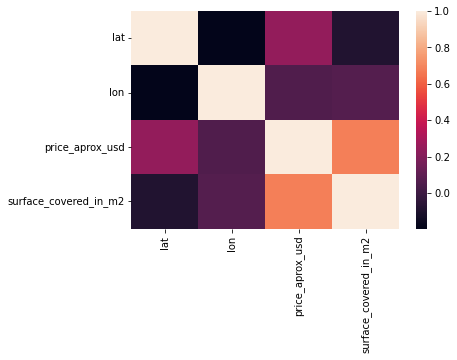

In [228]:
sns.heatmap(df.corr());

## Split

* Create the feature matrix named X_train that contain the features: ["lon", "lat", "surface_covered_in_m2", 
"neighborhood"]

Lets split the Surface area covered and the Price 

In [229]:
feature_metrix = ["lon", "lat", "surface_covered_in_m2", "neighborhood"]
X = df[feature_metrix]
print (X.shape)

(8640, 4)


In [230]:
target_vector = "price_aprox_usd"
y = df[target_vector]
print(y.shape)

(8640,)


* Split the whole data into two, the first set containing 70% of the whole data will be use to train the model while the other set will be used to test it

In [231]:
split = int(len(X)*0.7)

In [232]:
X_train  = pd.DataFrame(X.iloc[:split])
X_test = pd.DataFrame(X.iloc[split:])
print("Length of X_train=",X_train.shape[0])
print("Length of X_test=",X_test.shape[0])

Length of X_train= 6048
Length of X_test= 2592


In [233]:
y_train  = pd.DataFrame(y.iloc[:split])
y_test = pd.DataFrame(y.iloc[split:])
print("Length of y_train=",y_train.shape[0])
print("Length of y_test=",y_test.shape[0])

Length of y_train= 6048
Length of y_test= 2592


# Build Model

## Baseline Model

In [234]:
mean_train = y_train.mean()

In [235]:
# Create a list named y_pred_baseline that contains the value of y_mean repeated so that it's the same length at y_train
y_pred_baseline = [mean_train]*len(y_train)

* Calculate the baseline mean absolute error for your predictions in y_pred_baseline as compared to the true targets in y_train

In [236]:
print(f"mean absolute error = {mean_absolute_error(y_train, y_pred_baseline)}")

mean absolute error = 55660.32186945356


As expected, the baseline model doesn't really follow the trend in the data

## Iterate

* Create a pipeline named model that contains a OneHotEncoder and Ridge predictor

In [237]:
# Create a model
model = make_pipeline(OneHotEncoder(use_cat_names=True), Ridge())

In [238]:
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

## Evaluate

* Using the model's predict method, create a list of predictions for the observations in the feature matrix X_train named y_pred_training

In [239]:
# Generate predictions using a trained model in scikit-learn
y_pred_training = model.predict(X_train)

In [240]:
# Calculate the mean absolute error for a list of predictions in scikit-learn.
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 29604.74


* The model performs far better than the baseline. This suggests that the variables are strong predictors of price. 

* Now let's check our test performance. Remember, once we test our model, there's no more iteration allowed

In [241]:
# Generate predictions using a trained model in scikit-learn
y_pred_test = model.predict(X_test)

In [242]:
# Calculate the mean absolute error for a list of predictions in scikit-learn.
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Training MAE:", round(mae_test, 2))

Training MAE: 28057.38


* the mean absolute error for the test data is a less than that of the train data this indicate that the model will generalize well

# Communicate Result
In this section, I will craeate a tool for my stakeholders that can be used to deploy the model 

* Let's start with the intercept.

In [243]:
intercept = model.named_steps["ridge"].intercept_
print("Model Intercept:", np.round(intercept, 2))

Model Intercept: [10931681.84]


* Extract the coefficient associated "surface_covered_in_m2" in your model, and assign it to the variable coefficientdel

In [244]:
coefficients = np.round(model.named_steps["ridge"].coef_[0], 2)

In [245]:
coefficients

array([101326.44, 143951.23,   2223.67,  36650.22,  48629.98,  53380.72,
        37746.09,  11632.26,  39134.03,  25255.59,  28063.15,   3417.77,
         7910.16,  39591.33,  31669.09, -39629.35,  -8762.34,  -7518.68,
       -23911.72,  -9076.5 , -12259.24,  13815.45,  -9500.92, -17817.36,
         2905.49,   1188.06, -26436.05, 127944.4 , -29917.45, -45778.03,
       -21067.56, -14002.73, -22851.29, -36482.47, -25697.9 , -19869.34,
         7901.56,  -2552.38, -37630.29,  -5297.06,  -6434.86, -18491.69,
        10890.33, -29520.63,  -9853.99,  -4914.45, -21737.51, -36195.64,
       -16341.  ,  37157.41,  -5385.38, -13264.42,   7504.82,   -774.44,
        11766.67,  -5181.92])

We have the values of our coefficients, but how do we know which features they belong to? We'll need to get that information by going into the part of our pipeline that did the encoding

In [246]:
# Extract the feature names of your encoded data from the OneHotEncoder in your model
features_name = model.named_steps["onehotencoder"].get_feature_names()

* Create a pandas Series named feat_imp where the index is your features and the values are your coefficients

In [247]:
feat_coef = pd.Series(coefficients, index=features_name)
feat_coef.head()

lon                               101326.44
lat                               143951.23
surface_covered_in_m2               2223.67
neighborhood_Palermo               36650.22
neighborhood_Palermo Hollywood     48629.98
dtype: float64

* print the equation the model has determined for predicting apartment price based on neighborhood

In [248]:
print(f"price = {intercept.round(2)}")
for f, c in feat_coef.items():
    print(f"+ ({round(c, 2)} * {f})")

price = [10931681.84]
+ (101326.44 * lon)
+ (143951.23 * lat)
+ (2223.67 * surface_covered_in_m2)
+ (36650.22 * neighborhood_Palermo)
+ (48629.98 * neighborhood_Palermo Hollywood)
+ (53380.72 * neighborhood_Palermo Chico)
+ (37746.09 * neighborhood_Belgrano)
+ (11632.26 * neighborhood_Palermo Viejo)
+ (39134.03 * neighborhood_Las Cañitas)
+ (25255.59 * neighborhood_Barrio Norte)
+ (28063.15 * neighborhood_Palermo Soho)
+ (3417.77 * neighborhood_Capital Federal)
+ (7910.16 * neighborhood_Villa Crespo)
+ (39591.33 * neighborhood_Recoleta)
+ (31669.09 * neighborhood_Colegiales)
+ (-39629.35 * neighborhood_Balvanera)
+ (-8762.34 * neighborhood_Almagro)
+ (-7518.68 * neighborhood_Barracas)
+ (-23911.72 * neighborhood_Boca)
+ (-9076.5 * neighborhood_San Telmo)
+ (-12259.24 * neighborhood_Paternal)
+ (13815.45 * neighborhood_Caballito)
+ (-9500.92 * neighborhood_Villa General Mitre)
+ (-17817.36 * neighborhood_Flores)
+ (2905.49 * neighborhood_Villa del Parque)
+ (1188.06 * neighborhood_Villa

### Communicate Result Using Function and Widget

* Create a function that takes four arguments (area, lat, lon, and neighborhood) and returns your model's prediction for an apartment price.

In [249]:
def make_prediction(lon, lat, surface_covered_in_m2, neighborhood):
    df = {'lon':lon,
          'lat':lat,
          'surface_covered_in_m2':surface_covered_in_m2,
          'neighborhood':neighborhood
    }
    prediction = model.predict(pd.DataFrame(df, index=[0])).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [250]:
make_prediction(-34.565, -58.56435, 50, "Palermo")

'Predicted apartment price: $[-853243.34]'

* Creatte an interact widget that can predict apartment price changes by adjusting the widget variables

In [251]:
interact(
    make_prediction,
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    surface_covered_in_m2=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(FloatSlider(value=-58.42727415126141, description='lon', max=-58.3602735, min=-58.529034…